# PyTorch: Loading Data from AIStore 

Listing and loading data from AIS buckets (buckets that are not 3rd party backend-based) and remote cloud buckets (3rd party backend-based cloud buckets) using [AISFileLister](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.AISFileLister.html#aisfilelister) and [AISFileLoader](https://pytorch.org/data/main/generated/torchdata.datapipes.iter.AISFileLoader.html#torchdata.datapipes.iter.AISFileLoader).

In the following example, we use the [Caltech-256 Object Category Dataset](https://authors.library.caltech.edu/7694/) containing 256 object categories and a total of 30607 images stored on an AIS bucket and the [Microsoft COCO Dataset](https://cocodataset.org/#home) which has 330K images with over 200K labels of more than 1.5 million object instances across 80 object categories stored on Google Cloud. 

In [1]:
# Imports
import os
from IPython.display import Image

from torchdata.datapipes.iter import AISFileLister, AISFileLoader, Mapper

### Running the AIStore Cluster

[AIStore](https://github.com/NVIDIA/aistore) (AIS for short) is a highly available lightweight object storage system that specifically focuses on petascale deep learning. As a reliable redundant storage, AIS supports n-way mirroring and erasure coding. But it is not purely – or not only – a storage system: it’ll shuffle user datasets and run custom extract-transform-load workloads.

AIS is an elastic cluster that can grow and shrink at runtime and can be ad-hoc deployed, with or without Kubernetes, anywhere from a single Linux machine to a bare-metal cluster of any size. AIS fully supports Amazon S3, Google Cloud, and Microsoft Azure backends, providing a unified namespace across multiple connected backends and/or other AIS clusters, and [more](https://github.com/NVIDIA/aistore#features).

[Getting started with AIS](https://github.com/NVIDIA/aistore/blob/master/docs/getting_started.md) will take only a few minutes (prerequisites boil down to having a Linux with a disk) and can be done either by running a prebuilt [all-in-one docker image](https://github.com/NVIDIA/aistore/tree/master/deploy) or directly from the open-source.

To keep this example simple, we will be running a [minimal standalone docker deployment](https://github.com/NVIDIA/aistore/blob/master/deploy/prod/docker/single/README.md) of AIStore.

In [2]:
# Running the AIStore cluster in a container on port 51080
# Note: The mounted path should have enough space to load the dataset

! docker run -d \
    -p 51080:51080 \
    -v <path_to_gcp_config>.json:/credentials/gcp.json \
    -e GOOGLE_APPLICATION_CREDENTIALS="/credentials/gcp.json" \
    -e AWS_ACCESS_KEY_ID="AWSKEYIDEXAMPLE" \
    -e AWS_SECRET_ACCESS_KEY="AWSSECRETEACCESSKEYEXAMPLE" \
    -e AWS_DEFAULT_REGION="us-east-2" \
    -e AIS_BACKEND_PROVIDERS="gcp aws" \
    -v /disk0:/ais/disk0 \
    aistore/cluster-minimal:latest


b8bba47bb72fc6eb4f9692966a3975ee6d7334a1989e8d6fb33084ca9cf2743f


To create and put objects (dataset) in the bucket, I am going to be using [AIS CLI](https://github.com/NVIDIA/aistore/blob/master/docs/cli.md). But we can also use the [Python SDK](https://github.com/NVIDIA/aistore/tree/master/python/aistore) for the same.

In [3]:
! ais config cli set cluster.url=http://localhost:51080

# create bucket using AIS CLI
! ais bucket create caltech256

# put the downloaded dataset in the created AIS bucket
! ais object put -r -y <path_to_dataset> ais://caltech256/

"ais://caltech256" created (see https://github.com/NVIDIA/aistore/blob/master/docs/bucket.md#default-bucket-properties)
Files to upload:
EXTENSION	 COUNT	 SIZE
		 1	 3.06KiB
.jpg		 30607	 1.08GiB
TOTAL		30608	1.08GiB
PUT 30608 objects to "ais://caltech256"


### Preloaded dataset

The following assumes that AIS cluster is running and one of its buckets contains Caltech-256 dataset.

In [4]:
# list of prefixes which contain data
image_prefix = ["ais://caltech256/"]

# Listing all files starting with these prefixes on AIStore
dp_urls = AISFileLister(url="http://localhost:51080", source_datapipe=image_prefix)

# list first 5 obj urls
list(dp_urls)[:5]

['ais://caltech256/002.american-flag/002_0001.jpg',
 'ais://caltech256/002.american-flag/002_0002.jpg',
 'ais://caltech256/002.american-flag/002_0003.jpg',
 'ais://caltech256/002.american-flag/002_0004.jpg',
 'ais://caltech256/002.american-flag/002_0005.jpg']

image url: ais://caltech256/002.american-flag/002_0001.jpg


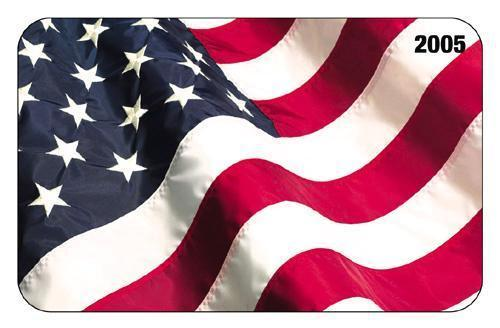

In [5]:
# loading data using AISFileLoader
dp_files = AISFileLoader(url="http://localhost:51080", source_datapipe=dp_urls)

# check the first obj
url, img = next(iter(dp_files))

print(f"image url: {url}")
Image(data=img.read())

In [6]:
def collate_sample(data):
    path, image = data
    dir = os.path.split(os.path.dirname(path))[1]
    label_str, cls = dir.split(".")
    return {"path": path, "image": image, "label": int(label_str), "cls": cls}

In [7]:
# passing it further down the pipeline
for _sample in Mapper(dp_files, collate_sample):
    pass

### Remote cloud buckets

AIStore supports multiple [remote backends](https://aiatscale.org/docs/providers). With AIS, accessing cloud buckets doesn't require any additional setup assuming, of course, that you have the corresponding credentials (to access cloud buckets).

For the following example, AIStore must be built and linked with the remote cloud provider backend which contains the dataset.

In [8]:
# list of prefixes which contain data
gcp_prefix = ["gcp://webdataset-testing/"]

# Listing all files starting with these prefixes on AIStore
gcp_urls = AISFileLister(url="http://localhost:51080", source_datapipe=gcp_prefix)

# list first 5 obj urls
list(gcp_urls)[:5]

['gcp://webdataset-testing/coco-train2014-seg-000000.tar',
 'gcp://webdataset-testing/coco-train2014-seg-000001.tar',
 'gcp://webdataset-testing/coco-train2014-seg-000002.tar',
 'gcp://webdataset-testing/coco-train2014-seg-000003.tar',
 'gcp://webdataset-testing/coco-train2014-seg-000004.tar']

In [9]:
dp_files = AISFileLoader(url="http://localhost:51080", source_datapipe=gcp_urls)

In [10]:
for url, file in dp_files.load_from_tar():
    pass

### References
- [AIStore](https://github.com/NVIDIA/aistore)
- [AIStore Blog](https://aiatscale.org/blog)
- [AIS CLI](https://github.com/NVIDIA/aistore/blob/master/docs/cli.md)
- [AIStore Cloud Backend Providers](https://aiatscale.org/docs/providers)
- [AIStore Documentation](https://aiatscale.org/docs)
- [AIStore Python SDK](https://github.com/NVIDIA/aistore/tree/master/python/aistore)
- [Caltech 256 Dataset](https://authors.library.caltech.edu/7694/)
- [Getting started with AIStore](https://github.com/NVIDIA/aistore/blob/master/docs/getting_started.md)
- [Microsoft COCO Dataset](https://cocodataset.org/#home)
